# Propensity Modeling Case Study

This notebook builds a full pipeline to identify clients with high propensity to buy **Consumer Loans**, **Credit Cards**, or **Mutual Funds**. The goal is to create a revenue-maximizing targeting strategy using explainable machine learning.

## Load and Inspect Data
Excel dataset containing:
- `Soc_Dem`: Demographic features
- `Products_ActBalance`: Existing product holdings and account balances
- `Inflow_Outflow`: Transaction-level behavior
- `Sales_Revenues`: Past sales outcomes and product revenue



In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report


# Read the Input Excel file
file_path = "/content/DataScientist_CaseStudy_Dataset.xlsx"
xls = pd.ExcelFile(file_path)

# Load each sheet into a DataFrame
soc_dem = xls.parse("Soc_Dem")
products_balance = xls.parse("Products_ActBalance")
inflow_outflow = xls.parse("Inflow_Outflow")
sales_revenues = xls.parse("Sales_Revenues")

##  Data Preprocessing
Encode categorical variables and fill missing values.

In [2]:
# Merge all sheets into a single DataFrame on Client
df = soc_dem.merge(products_balance, on="Client", how="left")
df = df.merge(inflow_outflow, on="Client", how="left")
df = df.merge(sales_revenues, on="Client", how="left")

# Encode categorical variables
df["Sex"] = LabelEncoder().fit_transform(df["Sex"])

# Fill missing values with 0
df.fillna(0, inplace=True)

## Define Features and Targets
We train three binary classification models to predict:
- `Sale_CL` → Consumer Loan
- `Sale_CC` → Credit Card
- `Sale_MF` → Mutual Fund

The corresponding revenue columns help compute expected financial return.

In [3]:
# Define targets and features
target_cols = {
    "Sale_CL": "Revenue_CL",
    "Sale_CC": "Revenue_CC",
    "Sale_MF": "Revenue_MF"
}

# Remove non-feature columns from the DataFrame
features = df.drop(columns=["Client"] + list(target_cols.keys()) + list(target_cols.values())).columns

## Modeling with XGBoost
We use XGBoost for its balance of performance and interpretability.
For each product, we:
- Split data
- Train model
- Evaluate with AUC & classification report
- Store SHAP values for explainability

In [4]:
results = {}

# For each product, train XGBoost model
for sale_col, revenue_col in target_cols.items():
    X = df[features]
    y = df[sale_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    # Predictions and AUC
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, model.predict(X_test), output_dict=True)

    # SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    # Top clients by predicted probability
    df[f"Propensity_{sale_col[-2:]}"] = model.predict_proba(X)[:, 1]

    # Save results
    results[sale_col] = {
        "model": model,
        "auc": auc,
        "report": report,
        "shap_values": shap_values,
        "X": X,
        "y": y,
        "revenue": df[revenue_col]
    }



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Model Evaluation
-  Classification Report
- AUC

In [5]:
# Print all classification reports stored in results
for sale_col, result in results.items():
    print(f"\nClassification Report for {sale_col}:\n")
    y_true = result["y"]
    y_pred = result["model"].predict(result["X"])
    print(classification_report(y_true, y_pred))


Classification Report for Sale_CL:

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      1325
         1.0       0.94      0.82      0.88       290

    accuracy                           0.96      1615
   macro avg       0.95      0.91      0.93      1615
weighted avg       0.96      0.96      0.96      1615


Classification Report for Sale_CC:

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1373
         1.0       0.97      0.82      0.89       242

    accuracy                           0.97      1615
   macro avg       0.97      0.91      0.94      1615
weighted avg       0.97      0.97      0.97      1615


Classification Report for Sale_MF:

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1422
         1.0       0.99      0.81      0.89       193

    accuracy                           0.98      1615
   macro avg     

In [6]:
# Return AUC scores
{key: round(value["auc"], 4) for key, value in results.items()}

{'Sale_CL': np.float64(0.613),
 'Sale_CC': np.float64(0.6095),
 'Sale_MF': np.float64(0.5824)}

## Revenue-Based Targeting Strategy
Using model probabilities and historical revenue:
- Estimate expected revenue for each client
- Recommend the best product per client
- Output a ranked targeting list

In [7]:
# Create Targeted_Client_List
df["Total_Expected_Revenue"] = (
    df["Propensity_CL"] * df["Revenue_CL"] +
    df["Propensity_CC"] * df["Revenue_CC"] +
    df["Propensity_MF"] * df["Revenue_MF"]
)

# Identify best offer for each client
df["Best_Offer"] = df[["Propensity_CL", "Propensity_CC", "Propensity_MF"]].idxmax(axis=1)
df["Best_Offer"] = df["Best_Offer"].str.replace("Propensity_", "")

# Final targeting list
targeted_client_list = df[["Client", "Best_Offer", "Propensity_CL", "Propensity_CC", "Propensity_MF", "Total_Expected_Revenue"]]
targeted_client_list_sorted = targeted_client_list.sort_values(by="Total_Expected_Revenue", ascending=False)

# Save to CSV
targeted_client_list_sorted.to_csv("/content/DataScientist_CaseStudy_Targeted_Client_List.csv", index=False)




## SHAP Explainability
SHAP to explain each model predictions


📊 SHAP Summary for Sale_CL


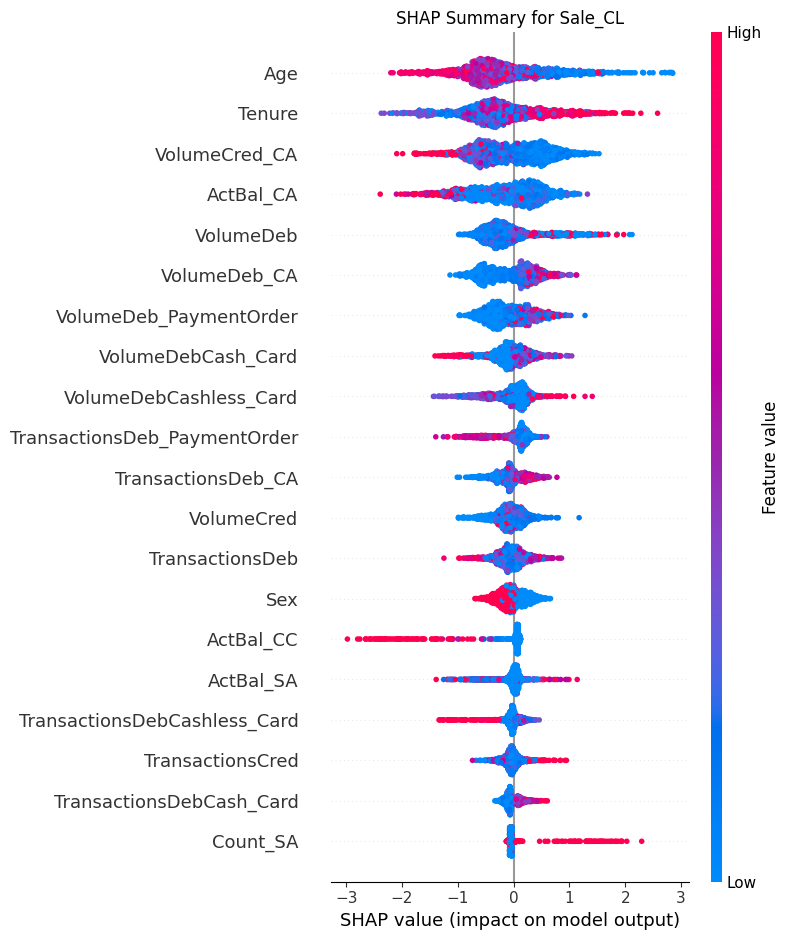


📊 SHAP Summary for Sale_CC


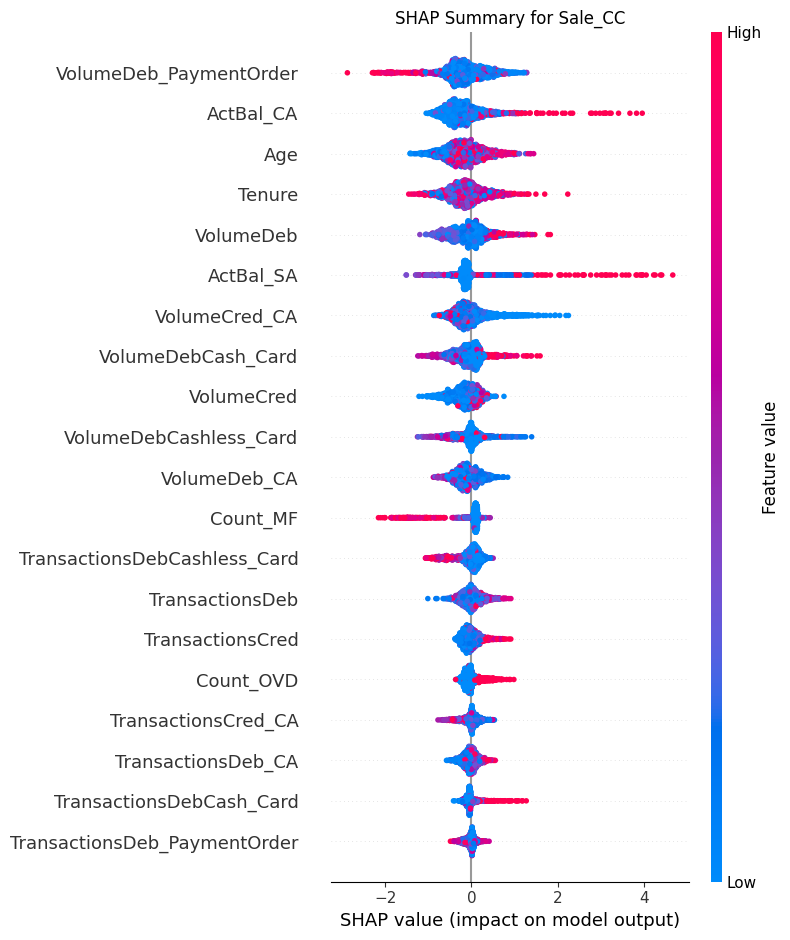


📊 SHAP Summary for Sale_MF


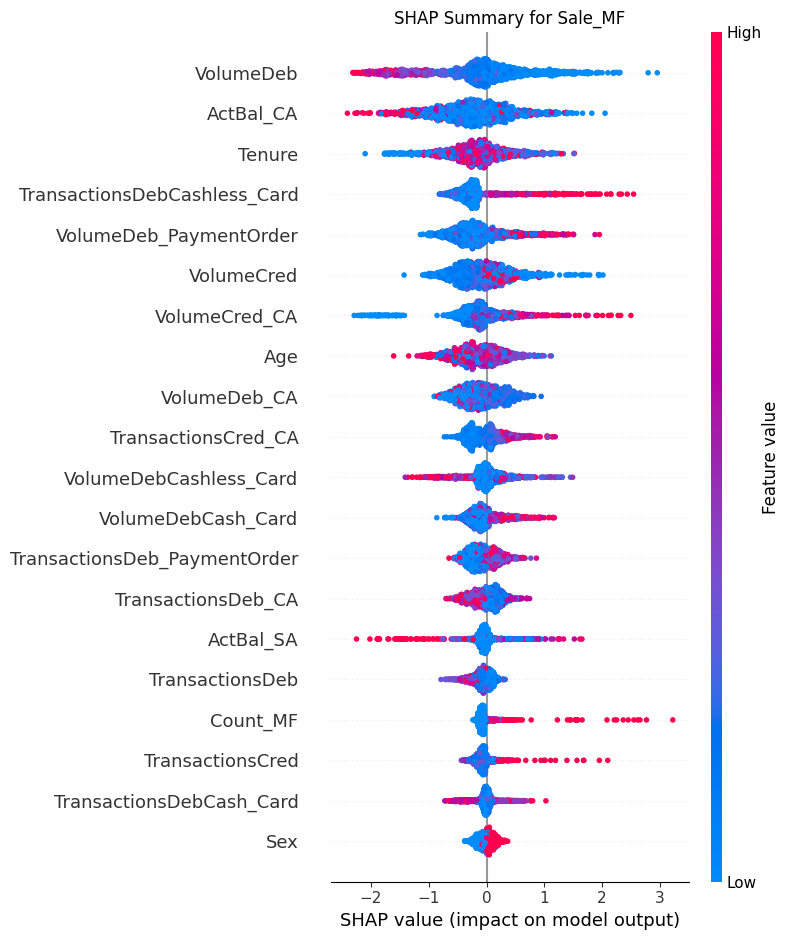

In [8]:
# SHAP Feature Importance Summary Plot for Each Model
for sale_col, res in results.items():
    print(f"\n📊 SHAP Summary for {sale_col}")
    shap.summary_plot(res["shap_values"], res["X"], show=False)
    plt.title(f"SHAP Summary for {sale_col}")
    plt.tight_layout()
    plt.show()


## Top 100 Clients
- Highlight the top 100 highest-value clients per product.

In [9]:
# Top 100 clients for each Best_Offer based on expected revenue
top_clients_per_product = df.groupby("Best_Offer", group_keys=False).apply(
    lambda x: x.nlargest(100, "Total_Expected_Revenue")
)[["Client", "Best_Offer", "Total_Expected_Revenue", "Propensity_CL", "Propensity_CC", "Propensity_MF"]]

top_clients_per_product.style.background_gradient(cmap='Greens')


/tmp/ipython-input-9-2712715766.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_clients_per_product = df.groupby("Best_Offer", group_keys=False).apply(


,Client,Best_Offer,Total_Expected_Revenue,Propensity_CL,Propensity_CC,Propensity_MF
1251,1335,CC,379.138449,0.013184,0.929346,0.011726
1101,448,CC,206.029515,0.269178,0.937567,0.009853
890,966,CC,155.157671,0.038071,0.761358,0.022671
800,479,CC,92.742795,0.000062,0.907940,0.008548
1301,374,CC,71.859213,0.042099,0.934945,0.002881
1613,629,CC,46.777007,0.046874,0.953063,0.022242
925,475,CC,39.766318,0.000458,0.931545,0.001821
690,388,CC,38.539638,0.856059,0.867576,0.005258
366,372,CC,36.614619,0.910029,0.919368,0.786543
79,236,CC,33.328844,0.900220,0.913053,0.007150
